In [1]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

import talos

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

In [2]:
# Fetch data and split into training-validation set and test set
mnist = fetch_openml("mnist_784", version = 1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.int8) # converting target to numbers instead of character
X_prevalidsplit, X_test, y_prevalidsplit, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [3]:
# Split set into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_prevalidsplit, y_prevalidsplit, random_state=42, test_size=0.2)

In [4]:
# Standardize Xs
scaler = StandardScaler()
X_train_tr = scaler.fit_transform(X_train)
X_valid_tr = scaler.transform(X_valid)
X_test_tr = scaler.transform(X_test)

# convert targets to one-hot vertors
y_train = tf.keras.utils.to_categorical(y_train)
y_valid = tf.keras.utils.to_categorical(y_valid)
y_test = tf.keras.utils.to_categorical(y_test)

Define neural network model as object to use for hyperparameters tunning (N of hidden layers, N of neurons within layer, regularization, batch size)

In [16]:
# helper function for tensorboard callback
root_logdir = os.path.join(os.curdir, "/Users/szymonmizak/machine_learning/mnist_project", "my_logs")
def get_run_logdir(): 
  run_id = time.strftime("run_%Y_%m%d-%H_%M_%S")
  return os.path.join(root_logdir, run_id)

In [17]:
# define callback to use in model function
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)

# define model generation function
def mnist_dense_model(x_tr, y_tr, x_val, y_val, params):
    # build model architecture
    model = Sequential()
    model.add(Input(shape=x_tr.shape[1])) 
    
    for l in params['hidden_layers']:
        model.add(tf.keras.layers.Dense(l, activation=params['activation']))
        if params['batch_normalization'] == True:
            model.add(BatchNormalization())

    model.add(Dropout(params['dropout_rate']))
    model.add(
        Dense(10, activation=params['last_activation'])
        ) 

    # compile model
    model.compile(optimizer = params['optimizer'](learning_rate = params['lr']), 
                  loss = params['losses'], 
                  metrics=['accuracy']) 
    # fit model
    history = model.fit(x_tr, y_tr, 
                        validation_data = [x_val, y_val], 
                        batch_size = params['batch_size'], 
                        callbacks = [early_stopping_cb, tf.keras.callbacks.TensorBoard(get_run_logdir())], 
                        epochs = params['epochs'],
                        verbose = 0
                        )
    return history, model

# Define hyperparameters grid
params_space = {
    'lr': [0.0001, 0.0003, 0.001, 0.003],
    'hidden_layers': [(256, 256), (256, 256, 256), (256, 256, 256, 256), 
                      (512, 512), (512, 512, 512), (512, 512, 512, 512)], 
    'shapes': ['brick'],     
    'batch_size': [8, 16, 32], 
    'epochs': [100], 
    'optimizer': [Adam], 
    'losses': ['categorical_crossentropy'], 
    'activation': ['relu'], 
    'last_activation': ['softmax'], 
    'dropout_rate': [0, .1, .2], 
    'batch_normalization': [True, False]
}

In [ ]:
# Run hyperparameters space scan using random search
scan_object = talos.Scan(X_train_tr, 
                         y_train, 
                         params_space, 
                         mnist_dense_model, 
                         "mnist", 
                         X_valid_tr, 
                         y_valid, 
                         print_params=True, 
                         fraction_limit=0.2)

In [84]:
# Extract experiment data
exp_data = scan_object.data[['val_accuracy', 'val_loss', 'hidden_layers', 'batch_size', 
                             'lr', 'dropout_rate', 'batch_normalization']]

In [85]:
# Inspect top 10 models
exp_data.sort_values('val_accuracy', ascending=False).head(10)

,val_accuracy,val_loss,hidden_layers,batch_size,lr,dropout_rate,batch_normalization
55,0.981583,0.113751,"(256, 256, 256, 256)",32,0.0030,0.1,True
4,0.981333,0.111182,"(256, 256, 256)",32,0.0010,0.0,True
51,0.981083,0.136872,"(256, 256, 256)",16,0.0010,0.2,True
26,0.979917,0.130991,"(256, 256, 256, 256)",32,0.0030,0.0,True
36,0.979833,0.138479,"(512, 512, 512)",16,0.0003,0.1,True
7,0.979833,0.130777,"(512, 512, 512, 512)",32,0.0030,0.2,True
65,0.979833,0.142738,"(512, 512, 512)",32,0.0003,0.2,True
64,0.979750,0.152722,"(256, 256, 256, 256)",16,0.0010,0.0,True
27,0.978500,0.135326,"(256, 256, 256, 256)",32,0.0003,0.0,False
38,0.978500,0.150524,"(256, 256)",32,0.0030,0.1,True


Results indicate that best models almost always include batch normalization and use 3/4 layers of size 256/512. Larger batch sizes seems to perform better. Learning rate varies but none of top models uses lowest value (0.0001).

In [81]:
# Inspect least 10 models
exp_data.sort_values('val_accuracy', ascending=True).head(10)

,val_accuracy,val_loss,hidden_layers,batch_size,lr,dropout_rate,batch_normalization
50,0.823333,1.329562,"(256, 256, 256)",8,0.003,0.2,False
12,0.888333,1.218413,"(512, 512)",8,0.003,0.1,False
32,0.905167,0.411715,"(512, 512)",8,0.003,0.0,False
18,0.916583,0.472727,"(512, 512, 512, 512)",16,0.003,0.1,False
46,0.938917,0.342228,"(512, 512, 512)",32,0.003,0.2,False
67,0.942250,0.302969,"(256, 256, 256, 256)",16,0.003,0.1,False
52,0.945417,0.449040,"(256, 256, 256)",16,0.003,0.0,False
11,0.954750,0.483098,"(256, 256)",16,0.003,0.0,False
77,0.956667,6.371877,"(512, 512, 512)",8,0.003,0.2,True
41,0.957333,0.238581,"(512, 512, 512, 512)",8,0.001,0.1,False


Worst models also show consistent pattern with no batch normalization, low batch size and largest tested learning rate. 

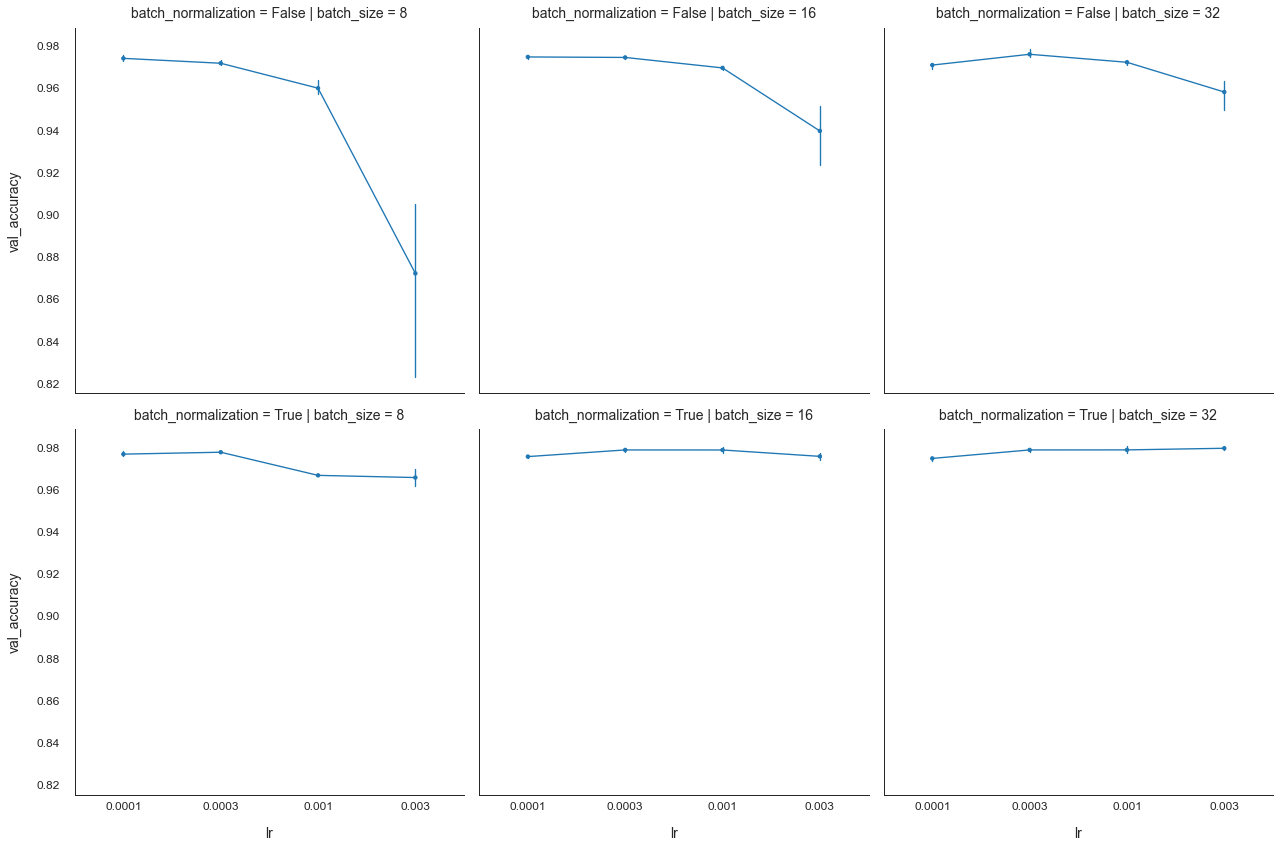

In [111]:
# Plot experiment results 
sns.set_style("ticks")
sns.set_palette("tab10")
fig = sns.FacetGrid(exp_data, col = 'batch_size', row='batch_normalization', height=6)
fig.map(sns.pointplot,'lr','val_accuracy')

When batch normalization is included larger learning rates do not lead to divergence. When it is missing problem appear most significant when using small batch size. Results indicate it would be reasonalbe to investigate even larger batch sizes. However running another scan would take long time and probably simple convolutional network will work better anyway. 

In [119]:
# Save best model to file
talos.Deploy(scan_object=scan_object, model_name='mnist_model', metric='val_accuracy')

Deploy package mnist_model have been saved.


In [120]:
# load model from file
best_model = talos.Restore('mnist_model.zip')

In [142]:
best_model.model.compile(optimizer=Adam(learning_rate=0.0030), 
                         loss='categorical_crossentropy', 
                         metrics=['accuracy'])
best_model.model.fit(X_train_tr, y_train, 
                     validation_data = [X_valid_tr, y_valid], 
                        batch_size = 32, 
                        callbacks = [early_stopping_cb, tf.keras.callbacks.TensorBoard(get_run_logdir())], 
                        epochs = 100,
                        verbose = 0
                        )

313/313 [==============================] - 1s 2ms/step


<AxesSubplot:>

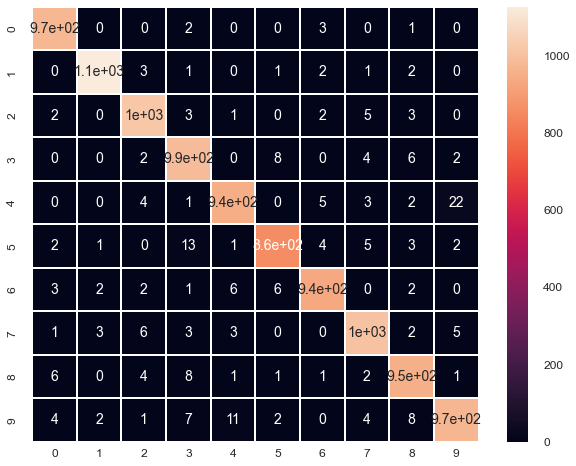

In [159]:
# create confusion matrix
predictions = best_model.model.predict(X_test_tr)
conf_matrix = tf.math.confusion_matrix(labels=tf.argmax(y_test, axis=1), predictions=tf.argmax(predictions, axis=1))
# plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, linecolor="white", linewidths=2)

Main type of errors are betweenp airs 5-3 and 9-4. 

In [164]:
# evaluate model on test set
test_results = best_model.model.evaluate(X_test_tr, y_test, verbose=0)
print("Testing accuracy of model is {} and loss is {}".format(round(test_results[1], 3), round(test_results[0], 3)))

Testing accuracy of model is 0.977 and loss is 0.089
